Inspired by https://github.com/keras-team/keras/blob/master/examples/image_ocr.py and https://hackernoon.com/latest-deep-learning-ocr-with-keras-and-supervisely-in-15-minutes-34aecd630ed8

In [1]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.8.0
Keras version: 2.2.0


In [2]:
import os
from os.path import join
import json
import random
import itertools
#import re
#import datetime
#import cairocffi as cairo
#import editdistance
#from scipy import ndimage
#import pylab
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
#from keras.utils.data_utils import get_file
#from keras.preprocessing import image
#import keras.callbacks

In [3]:
sess = tf.Session()
K.set_session(sess)

In [4]:
DATASET_TRAIN = 'data/ocr_reader__train'
DATASET_TEST = 'data/ocr_reader__test'
DATASET_RNG = 'data/ocr_rng'
DATASET_RNG_TEST = 'data/ocr_rng__test'
MODEL_FILE = 'model/ocr_v1.h5'

In [5]:
def clipped_relu(x):
    return relu(x, max_value=20)

# Get Decoded Letters

We use genertaed numberic data

In [6]:
letters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']
n_letters = len(letters)
print('Possible decode letters:', ' '.join(letters))

Possible decode letters: 0 1 2 3 4 5 6 7 8 9 .


# Model Parameters

First couple letter decoded from RNN will usually garbaged. This tweak make model a little bit more robust. 

In [7]:
rnn_skip_characters = 0 #2
img_w = 400
img_h = 400

# Input data generator

In [8]:
# Convert label vector to string
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)] if int(x) < n_letters else '', labels)))

# Convert string to label vector size: $max_text_len
def text_to_labels(text, max_text_len):
    # add blank to fill $max_text_len
    return list(map(lambda x: letters.index(x), text)) + [ n_letters ] * (max_text_len - len(text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

In [9]:
class TextImageGenerator:
    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                ann = json.load(open(json_filepath, 'r'))
                description = ann['description']
                tags = ann['tags']
                if tag not in tags:
                    continue
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return n_letters + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - rnn_skip_characters)
            label_length = np.zeros((self.batch_size, 1))
            # source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text, self.max_text_len)
                # source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [10]:
class TextImageRNG:
    
    def __init__(self,
                 dirpath,
                 img_w,
                 img_h,
                 batch_size,
                 downsample_factor,
                 max_text_len=8,
                 train_step=500,
                 p_replay=0):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        self.train_step = train_step
        self.p_replay = p_replay
        self.n_replay = int(train_step * p_replay)
        if p_replay == 0:
            self.next_sample = self.generate_sample
        
        self.imgs = []
        self.samples = []
        self.replay = []
        for filename in os.listdir(dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = join(dirpath, filename)
                self.samples.append(img_filepath)
        
        self.n = len(self.samples)
        
    def build_data(self):
        for i, img_filepath in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            self.imgs.append(img)
    
    def get_output_size(self):
        return n_letters + 1
    
    # Use idea from RL Replay experience
    # make some sample reoccurs in train data so it could converge faster
    def next_sample(self):
        do_replay = random.random() < self.p_replay
        if len(self.replay) > self.n_replay // 2 and do_replay:
            return random.choice(self.replay)
        else:
            sample_pair = self.generate_sample()
            if do_replay:
                self.replay.append(sample_pair)
            return sample_pair
    
    def replay_trim(self):
        random.shuffle(self.replay)
        if len(self.replay) > self.n_replay:
            self.replay = self.replay[:self.n_replay-1]
    
    def generate_sample(self):
        img_index = 0
        #img_index = random.randint(0, self.n-1)
        img = np.copy(self.imgs[img_index])
        rng_number = self.next_rng()
        
        # Generate Text Style
        font      = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (0,0,0)
        
        if img_index == 0:
            fontScale = 0.6
            lineType  = 2
            text_x = 150
            text_y = 375
        elif img_index == 1:
            fontScale = 0.4
            lineType  = 2
            text_x = 205
            text_y = 200
        elif img_index == 2:
            fontScale = 0.35
            lineType  = 2
            text_x = 310
            text_y = 290
        
        textsize = cv2.getTextSize(rng_number, font, fontScale, lineType)
        text_width, text_height = textsize[0][0], textsize[0][1]
        cv2.putText(img, rng_number, (text_x-text_width, text_y), font, fontScale, fontColor, lineType)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)
        img /= 255
        
        return img, rng_number
    
    def next_rng(self):
        power = random.randint(2, 4)
        rng = random.uniform(10 ** power, (10 ** (power+1)) - 1)
        return "%.2f" % rng
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.zeros([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.zeros([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - rnn_skip_characters)
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T # Transpose
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text, self.max_text_len)
                label_length[i] = len(text)
            
            self.replay_trim()
            
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)
    

In [11]:
tiger = TextImageRNG(DATASET_RNG, 400, 400, batch_size=8, downsample_factor=16)
tiger.build_data()

Text generator output (data which will be fed into the neutral network):
1) the_input (image)


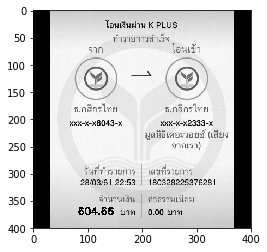

2) the_labels (plate number): 604.66 is encoded as [6, 0, 4, 10, 6, 6, 11, 11]
3) input_length (width of image that is fed to the loss function): 25 == 400 / 16 - 0
4) label_length (length of plate number): 6


In [12]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / %d - %d' % 
          (inp['input_length'][0], tiger.img_w, tiger.downsample_factor, rnn_skip_characters))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

# Loss and train functions, network architecture

In [13]:
history = None

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    # hack for load_model
    import tensorflow as tf
    
    # the ${rnn_skip_characters} (2) is critical here since the first couple outputs of the RNN tend to be garbage:
    #y_pred = y_pred[:, rnn_skip_characters:, :]
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def train(epochs=1, load=False, model_train=True):
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 4
    time_dense_size = 32
    rnn_size = 60    
    batch_size = 32
    downsample_factor = pool_size ** 2

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
    
    tiger_train = TextImageRNG(DATASET_RNG, img_w, img_h, batch_size, downsample_factor, p_replay=0.7, train_step=500)
    tiger_train.build_data()
    tiger_val = TextImageRNG(DATASET_RNG, img_w, img_h, batch_size, downsample_factor, train_step=10)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.8, nesterov=True, clipnorm=5)

    if load:
        model = load_model(MODEL_FILE)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if model_train:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        history = model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.train_step,
                            epochs=epochs, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.train_step)

    return model

# Model description and training

Next block will take about 30 minutes.

In [14]:
model = train(epochs=10, load=False, model_train=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 400, 400, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 400, 16) 160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 100, 100, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 100, 100, 16) 2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

# Training progress

In [15]:
print('winner write history')

winner write history


# Function to decode neural network output

In [16]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, rnn_skip_characters:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < n_letters:
                outstr += letters[c]
        ret.append(outstr)
    return ret

# Test on validation images

Predicted: 317.79
True: 317.79


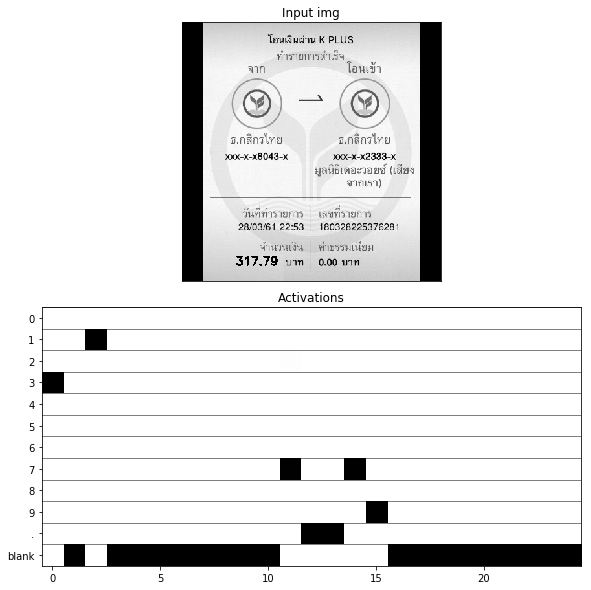

Predicted: 4155.48
True: 4155.48


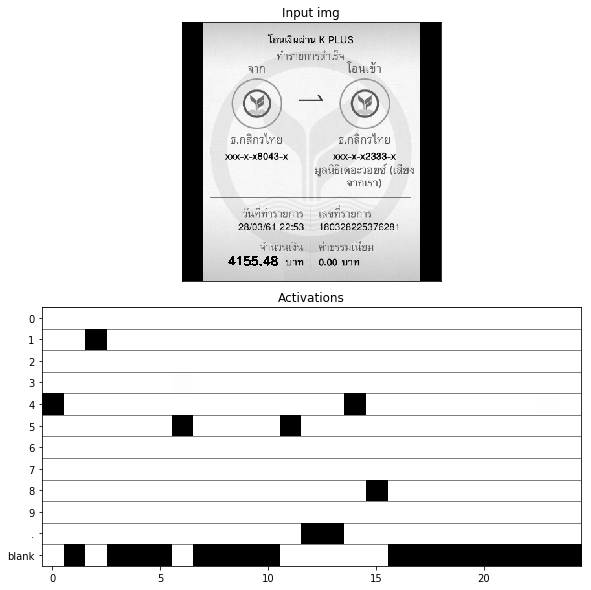

Predicted: 40304.01
True: 40304.01


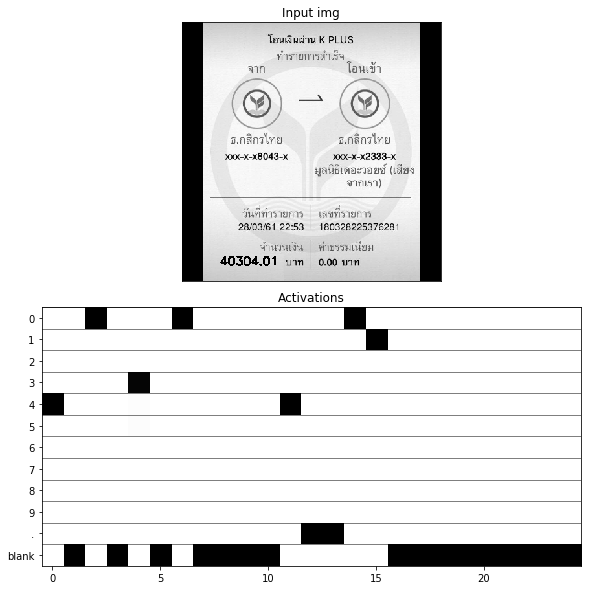

Predicted: 2732.76
True: 2732.76


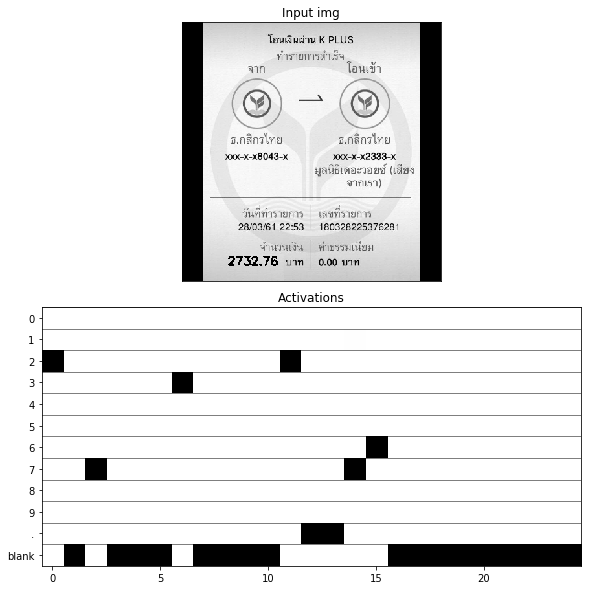

Predicted: 861.57
True: 861.57


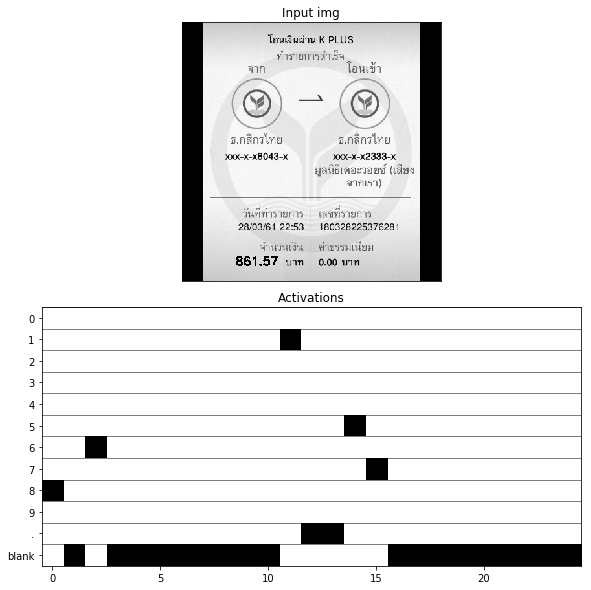

Predicted: 5113.46
True: 5113.46


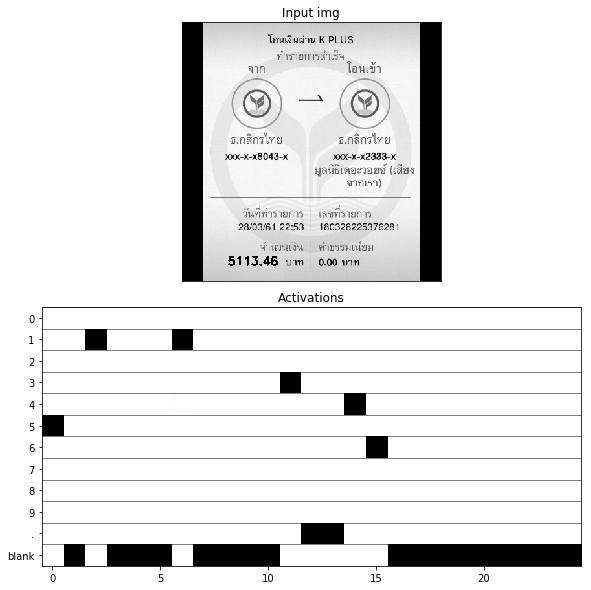

Predicted: 699.54
True: 699.54


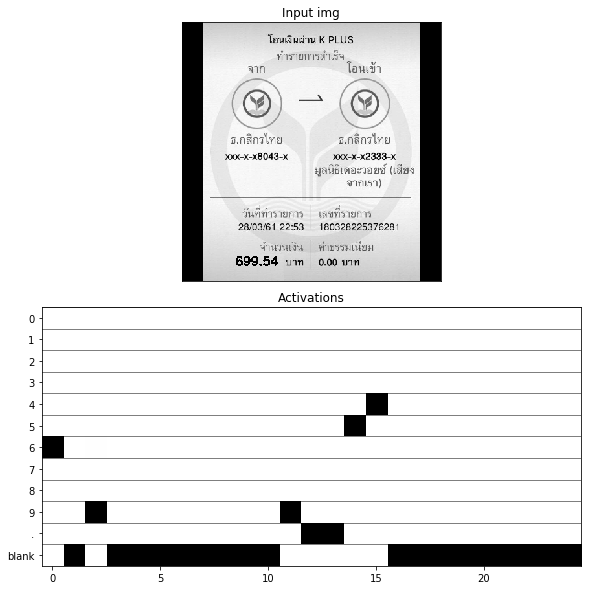

Predicted: 646.21
True: 646.21


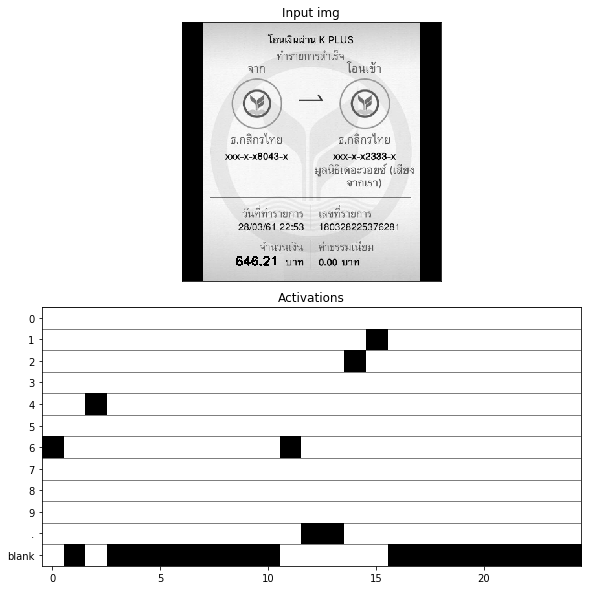

In [91]:
#tiger_test = TextImageGenerator(DATASET_TEST, 'test', 400, 400, 8, 16)
tiger_test = TextImageRNG(DATASET_RNG, img_w, img_h, 8, 16)
tiger_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in tiger_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        #text = ''.join(list(map(lambda x: letters[int(x)], label)))
        text = labels_to_text(label)
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

# Don't forget the good deed

In [17]:
model.save('model/ocr_v2.h5')